# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib.pylab as plb 

import patsy
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline

# Import dataset from Heroku

In [2]:
from getpass import getpass
password = getpass('Enter database password')

connection = psycopg2.connect(user="azcaqpdjrciaow",
                                  password=password,
                                  host="ec2-34-226-18-183.compute-1.amazonaws.com",
                                  port="5432",
                                  database="d7m85rf8c5rhv5")
cursor = connection.cursor()
postgreSQL_select_Query = "select * from player_market_values where season = 2018 or season = 2017"

cursor.execute(postgreSQL_select_Query)
print("Loading data from Heroku")

data = cursor.fetchall()
df = pd.DataFrame(data, columns=['player_id', 'player_name', 'age', 'club_id', \
                                                    'team_from', 'league_from', 'team_to', 'country_of_birth', \
                                                    'country_of_citizenship', 'player_position', 'games', 'goals', \
                                                    'assists', 'hours_played', 'yellow_cards', 'red_cards', 'transfer_fee', \
                                                    'market_value', 'club_market_value', 'season'])
Football_df = df.drop(columns=['player_id', 'player_name', 'club_id', 'team_from', 'league_from', 'team_to', 'country_of_birth', 'country_of_citizenship', 'season'])
Football_df

Enter database password········
Loading data from Heroku


,age,player_position,games,goals,assists,hours_played,yellow_cards,red_cards,transfer_fee,market_value,club_market_value
0,25,Attack,27,25,16,40.4500,8,0,222000000,100000000,891180000
1,33,Attack,43,28,10,60.7667,4,1,117000000,100000000,816530000
2,25,Midfield,42,21,15,49.8833,1,0,125000000,90000000,604800000
3,22,Midfield,43,3,6,43.5333,5,0,70000000,65000000,671310000
4,25,Goalkeeper,51,0,0,76.5000,1,0,62500000,60000000,779850000
...,...,...,...,...,...,...,...,...,...,...,...
344,20,Midfield,1,0,0,0.1500,0,0,10000000,800000,301820000
345,20,Midfield,1,0,0,1.5000,0,0,5000000,800000,373820000
346,19,Attack,1,0,0,0.2500,0,0,5000000,800000,9050000
347,22,Defender,22,0,1,29.7333,3,0,5000000,600000,98420000


# Encoding categorical variables
#### hours_played converted to float
#### player_position to dummie variables

In [3]:
Football_df["hours_played"] = pd.to_numeric(Football_df.hours_played, downcast="float")
Football_cat= Football_df.dtypes[Football_df.dtypes == "object"].index.tolist()
Football_cat

['player_position']

In [4]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(Football_df[Football_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(Football_cat)
encode_df.head()

,player_position_0,player_position_Attack,player_position_Defender,player_position_Goalkeeper,player_position_Midfield
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0


In [5]:
# Merge one-hot encoded features and drop the originals
Football_df = Football_df.merge(encode_df, left_index=True, right_index=True)
Football_df.drop(Football_cat,1, inplace=True)
Football_df.head()

,age,games,goals,assists,hours_played,yellow_cards,red_cards,transfer_fee,market_value,club_market_value,player_position_0,player_position_Attack,player_position_Defender,player_position_Goalkeeper,player_position_Midfield
0,25,27,25,16,40.450001,8,0,222000000,100000000,891180000,0.0,1.0,0.0,0.0,0.0
1,33,43,28,10,60.766701,4,1,117000000,100000000,816530000,0.0,1.0,0.0,0.0,0.0
2,25,42,21,15,49.883301,1,0,125000000,90000000,604800000,0.0,0.0,0.0,0.0,1.0
3,22,43,3,6,43.533298,5,0,70000000,65000000,671310000,0.0,0.0,0.0,0.0,1.0
4,25,51,0,0,76.500000,1,0,62500000,60000000,779850000,0.0,0.0,0.0,1.0,0.0


In [6]:
Football_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         349 non-null    int64  
 1   games                       349 non-null    int64  
 2   goals                       349 non-null    int64  
 3   assists                     349 non-null    int64  
 4   hours_played                349 non-null    float32
 5   yellow_cards                349 non-null    int64  
 6   red_cards                   349 non-null    int64  
 7   transfer_fee                349 non-null    int64  
 8   market_value                349 non-null    int64  
 9   club_market_value           349 non-null    int64  
 10  player_position_0           349 non-null    float64
 11  player_position_Attack      349 non-null    float64
 12  player_position_Defender    349 non-null    float64
 13  player_position_Goalkeeper  349 non

# Distribution of age for each Players

C:\Users\18176\anaconda3\envs\PythonData\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


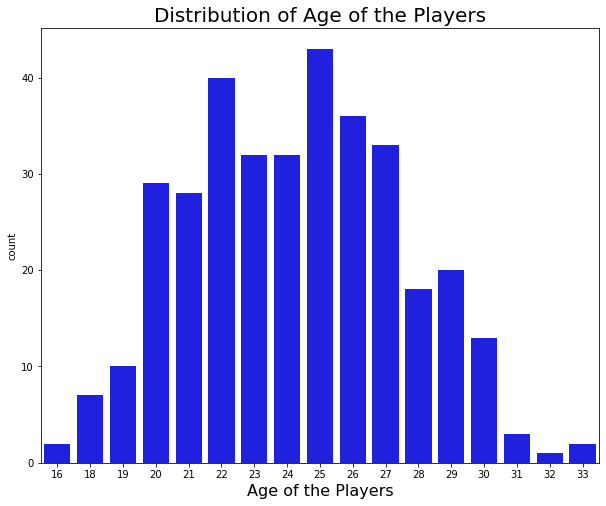

In [58]:
x = Football_df['age']
plt.figure(figsize=(10,8))
ax = sns.countplot(x,color='blue')
ax.set_xlabel(xlabel = 'Age of the Players', fontsize = 16)
ax.set_title(label = 'Distribution of Age of the Players', fontsize = 20)
plt.show()
fig.savefig("Distribution .png") 

# Distribution of Age By Market Value and Transfer Fee

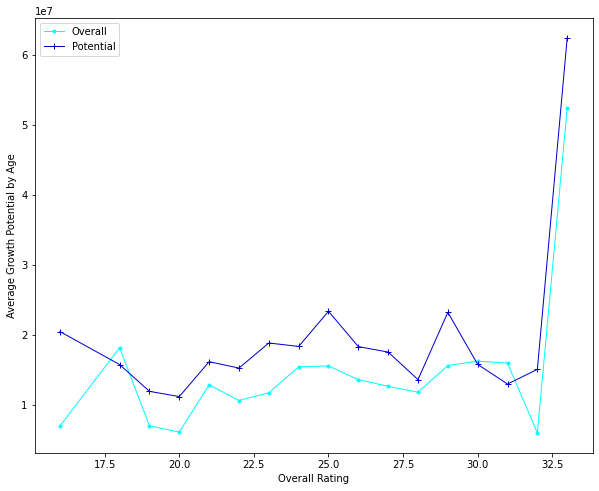

In [54]:
overall = pd.DataFrame(Football_df.groupby(["age"])['market_value'].mean())
Maket_value = pd.DataFrame(Football_df.groupby(["age"])['transfer_fee'].mean())

merged = pd.merge(overall, Maket_value, on='age', how='inner')
merged['age']= merged.index

fig, ax = plt.subplots(figsize=(10,8))

merged.reset_index(drop = True, inplace = True)

plt.plot('age', 'market_value', data=merged, marker='.', color='#00ffff', lw=1, label ="Overall" )
plt.plot('age', 'transfer_fee', data=merged, marker='+', color='#0000cc', lw=1, label = "Potential")
plt.xlabel('Overall Rating')
plt.ylabel('Average Growth Potential by Age')
plt.legend();
fig.savefig("Distribution of Age By Market Value and Transfer Fee") 

# Correlation plot
#### Variables related to market value: transfer_fee, club_market_value, assists, goals, games, hours_played

C:\Users\18176\anaconda3\envs\PythonData\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


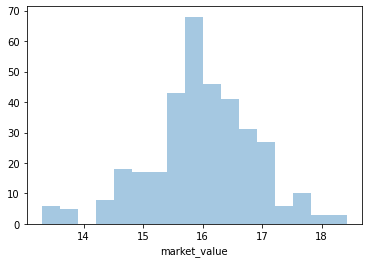

In [55]:
X = Football_df[['age','games', 'goals','assists','hours_played', 'yellow_cards', 
          'red_cards', 'transfer_fee', 'club_market_value']]
y = np.log1p(Football_df['market_value'])
sns.distplot(y,kde=False)
fig.savefig("Correlation plot") 

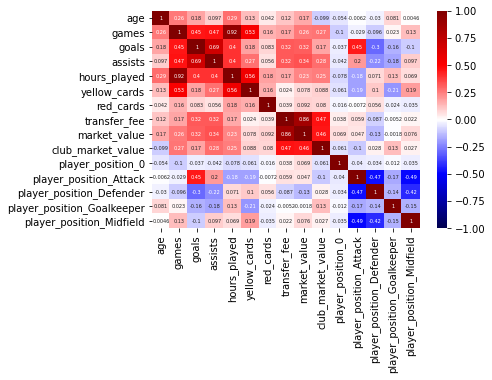

In [10]:
features_map = sns.heatmap(Football_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, annot_kws={"fontsize":5})
fig = features_map.get_figure()
 

# Heat Map

In [11]:

#visualizer = Rank2D(algorithm="pearson")
#visualizer.fit_transform(Football_df.corr())


<AxesSubplot:>

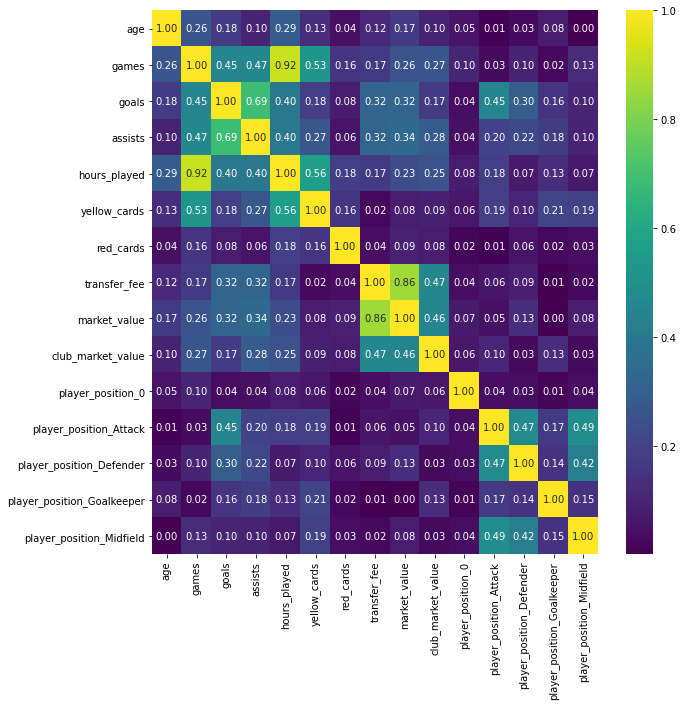

In [12]:
Football_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(np.abs(Football_df.corr()), annot=True, cmap="viridis", fmt="0.2f")

In [13]:
x, y = Football_df.drop('market_value',axis=1), Football_df['market_value']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20) 

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [15]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# Higher alpha = strong regularization strength 
lm_las = Lasso(alpha=0.01)
lm_reg = Ridge(alpha=0.01)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

C:\Users\18176\anaconda3\envs\PythonData\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

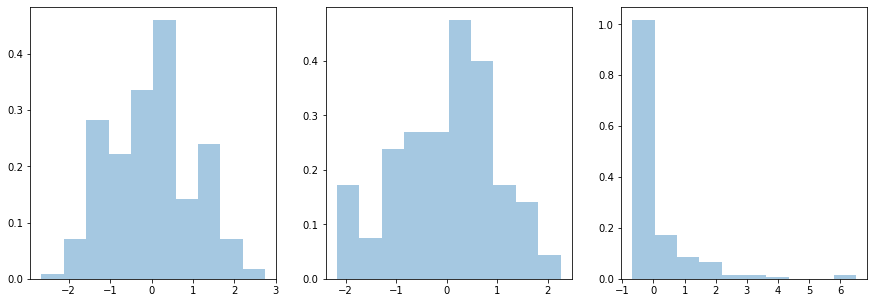

In [16]:
# Plot histograms of a few transformed variables
# Note that they seem to have means of 0 and stddevs of 1
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.distplot(X_train_scaled[:, 0], label='feature 1', ax=axes[0], kde=False, bins=10, norm_hist=True)
sns.distplot(X_train_scaled[:, 1], label='feature 2', ax=axes[1], kde=False, bins=10, norm_hist=True)
sns.distplot(X_train_scaled[:, 2], label='feature 3', ax=axes[2], kde=False, bins=10, norm_hist=True)

In [17]:
lm.fit(X_train_scaled, y_train)
print(f'Linear Regression Train R^2: {lm.score(X_train_scaled, y_train):.3f}')
print(f'Linear Regression Val R^2: {lm.score(X_val_scaled, y_val):.3f}')
print(f'Linear Regression Test R^2: {lm.score(X_test_scaled, y_test):.3f}\n')

lm_las.fit(X_train_scaled, y_train)

print(f'Lasso Regression Train R^2: {lm_las.score(X_train_scaled, y_train):.3f}')
print(f'Lasso Regression Val Scaled R^2: {lm_las.score(X_val_scaled, y_val):.3f}')
print(f'Lasso Regression Test R^2: {lm_las.score(X_test_scaled, y_test):.3f}\n')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression Train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression Val Scaled R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')
print(f'Ridge Regression Test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}\n')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression Train R^2: {lm_poly.score(X_train_poly, y_train):.3f}')
print(f'Degree 2 polynomial regression Val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
print(f'Degree 2 polynomial regression Test R^2: {lm_poly.score(X_test_poly, y_test):.3f}')

Linear Regression Train R^2: 0.816
Linear Regression Val R^2: 0.534
Linear Regression Test R^2: 0.540

Lasso Regression Train R^2: 0.816
Lasso Regression Val Scaled R^2: 0.534
Lasso Regression Test R^2: 0.540

Ridge Regression Train R^2: 0.816
Ridge Regression Val Scaled R^2: 0.534
Ridge Regression Test R^2: 0.540

Degree 2 polynomial regression Train R^2: 0.818
Degree 2 polynomial regression Val R^2: 0.221
Degree 2 polynomial regression Test R^2: -2.685


In [18]:
#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [19]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_train_r2s, cv_lm_val_r2s, cv_lm_las_train_r2s, cv_lm_las_val_r2s, cv_lm_reg_train_r2s, cv_lm_reg_val_r2s, cv_lm_poly_train_r2s, cv_lm_poly_val_r2s, rmses, rmses_las, rmses_reg, rmses_poly = [], [], [], [], [], [], [], [], [], [], [], [] #collect the validation results for models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm.fit(X_train, y_train)
    cv_lm_train_r2s.append(lm.score(X_train, y_train))
    cv_lm_val_r2s.append(lm.score(X_val, y_val))

    lm_rmse = mean_squared_error(y_val, lm.predict(X_val), squared=False)
    rmses.append(lm_rmse)

    # setup for ridge, lasso, and polynomial
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    #lass with feature scaling 
    lm_las.fit(X_train_scaled, y_train)
    cv_lm_las_train_r2s.append(lm_las.score(X_val_scaled,y_val))
    cv_lm_las_val_r2s.append(lm_las.score(X_val_scaled, y_val))

    lm_las_rmse = mean_squared_error(y_val, lm_las.predict(X_val_scaled), squared=False)
    rmses_las.append(lm_las_rmse)

    #ridge with feature scaling
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_train_r2s.append(lm_reg.score(X_val_scaled,y_val))
    cv_lm_reg_val_r2s.append(lm_reg.score(X_val_scaled, y_val))

    lm_reg_rmse = mean_squared_error(y_val, lm_reg.predict(X_val_scaled), squared=False)
    rmses_reg.append(lm_reg_rmse)

    #polynomial with feature scaling
    lm_poly.fit(X_train_scaled, y_train)
    cv_lm_poly_train_r2s.append(lm_las.score(X_val_scaled,y_val))
    cv_lm_poly_val_r2s.append(lm_poly.score(X_val_scaled, y_val))

    lm_poly_rmse = mean_squared_error(y_val, lm_poly.predict(X_val_scaled), squared=False)
    rmses_poly.append(lm_poly_rmse)

print('Simple regression scores: ', cv_lm_val_r2s)
print('Lasso scores: ', cv_lm_las_val_r2s, '\n')
print('Ridge scores: ', cv_lm_reg_val_r2s, '\n')
print('Polynomial scores:', cv_lm_poly_val_r2s, '\n')

print(f'Lasso mean cv r^2 (TRAIN): {np.mean(cv_lm_las_train_r2s):.3f} +- {np.std(cv_lm_las_train_r2s):.3f}')
print(f'Lasso mean cv r^2 (VAL): {np.mean(cv_lm_las_val_r2s):.3f} +- {np.std(cv_lm_las_val_r2s):.3f}')
print(f'Lasso mean RMSE: {np.mean(rmses_las):.3f} +- {np.std(rmses_las):.3f}\n')

print(f'Ridge mean cv r^2 (TRAIN): {np.mean(cv_lm_reg_train_r2s):.3f} +- {np.std(cv_lm_reg_train_r2s):.3f}')
print(f'Ridge mean cv r^2 (VAL): {np.mean(cv_lm_reg_val_r2s):.3f} +- {np.std(cv_lm_reg_val_r2s):.3f}')
print(f'Ridge mean RMSE: {np.mean(rmses_reg):.3f} +- {np.std(rmses_reg):.3f}\n')

print(f'Polynomial mean cv r^2 (TRAIN): {np.mean(cv_lm_poly_train_r2s):.3f} +- {np.std(cv_lm_poly_train_r2s):.3f}')
print(f'Polynomial mean cv r^2 (VAL): {np.mean(cv_lm_poly_val_r2s):.3f} +- {np.std(cv_lm_poly_val_r2s):.3f}')
print(f'Polynomial mean RMSE: {np.mean(rmses_poly):.3f} +- {np.std(rmses_poly):.3f}\n')

print(f'Simple mean cv r^2 (TRAIN): {np.mean(cv_lm_train_r2s):.3f} +- {np.std(cv_lm_train_r2s):.3f}')
print(f'Simple mean cv r^2 (VAL): {np.mean(cv_lm_val_r2s):.3f} +- {np.std(cv_lm_val_r2s):.3f}')
print(f'Simple mean RMSE: {np.mean(rmses):.3f} +- {np.std(rmses):.3f}')

Simple regression scores:  [0.6622958307125585, 0.6952591179001522, 0.8364225659550719, 0.7601545617061104, 0.7640051253266487]
Lasso scores:  [0.6622958300923698, 0.6952591191130576, 0.8364225662672091, 0.760154562753194, 0.7640051250885271] 

Ridge scores:  [0.6623053575630861, 0.695272841828066, 0.8364149485358321, 0.7601530258764349, 0.7640132248751903] 

Polynomial scores: [0.6622958307269693, 0.6952591179621532, 0.8364225659314164, 0.7601545617054072, 0.764005125320258] 

Lasso mean cv r^2 (TRAIN): 0.744 +- 0.060
Lasso mean cv r^2 (VAL): 0.744 +- 0.060
Lasso mean RMSE: 6400773.702 +- 433928.373

Ridge mean cv r^2 (TRAIN): 0.744 +- 0.060
Ridge mean cv r^2 (VAL): 0.744 +- 0.060
Ridge mean RMSE: 6400737.070 +- 433897.016

Polynomial mean cv r^2 (TRAIN): 0.744 +- 0.060
Polynomial mean cv r^2 (VAL): 0.744 +- 0.060
Polynomial mean RMSE: 6400773.707 +- 433928.367

Simple mean cv r^2 (TRAIN): 0.784 +- 0.014
Simple mean cv r^2 (VAL): 0.744 +- 0.060
Simple mean RMSE: 6400773.707 +- 433928.

In [20]:
list(zip(Football_df.columns[:-1],lm_las.coef_))

[('age', 446922.64362283004),
 ('games', 1463009.6190890956),
 ('goals', -161802.19681177143),
 ('assists', 396312.768357952),
 ('hours_played', -1221944.2409034772),
 ('yellow_cards', 882315.5456436739),
 ('red_cards', 730411.7676142165),
 ('transfer_fee', 10427589.243879382),
 ('market_value', 808468.1513093894)]

In [21]:
list(zip(Football_df.columns[:-1],lm_reg.coef_))

[('age', 446970.3324630296),
 ('games', 1462349.1213321746),
 ('goals', -161685.30294538155),
 ('assists', 396344.27502113784),
 ('hours_played', -1221186.4068248572),
 ('yellow_cards', 882124.6831846063),
 ('red_cards', 730445.0949784181),
 ('transfer_fee', 10426910.93500779),
 ('market_value', 808767.0014507018)]

In [22]:
test_set_pred = lm_las.predict(X_test)

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

382044784632672.75

In [23]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

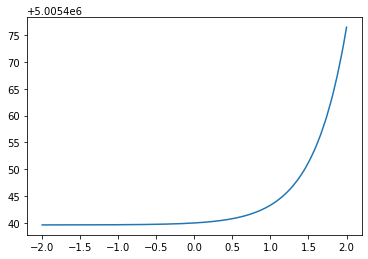

In [24]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

In [25]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

5005439.645675156

In [26]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)]

0.01

In [27]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('Ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)

In [28]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

4998980.6962934425

In [29]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lm_las_CV = LassoCV(alphas = alphavec, cv=5)
lm_las_CV.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [30]:
# This is the best alpha value it found - higher from the value
# selected using simple validation
lm_las_CV.alpha_

100.0

In [31]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lm_reg_CV = RidgeCV(alphas = alphavec, cv=5)
lm_reg_CV.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [32]:
# This is the best alpha value it found - higher from the value
# selected using simple validation
lm_reg_CV.alpha_

9.884959046625585

Text(0, 0.5, 'Actual Values')

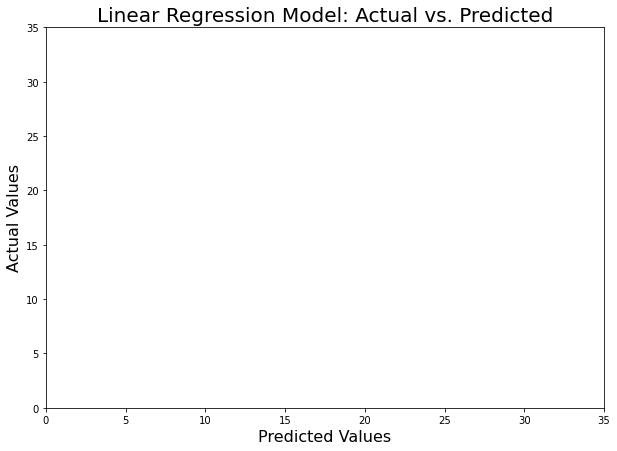

In [33]:
lm_predict = lm.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_predict, y_test)
ax = plt.gca()

z = np.polyfit(lm_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_predict, p(lm_predict), "m-")

plt.xlim(0,35)
plt.ylim(0,35)

plt.title('Linear Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

Text(0, 0.5, 'Actual Values')

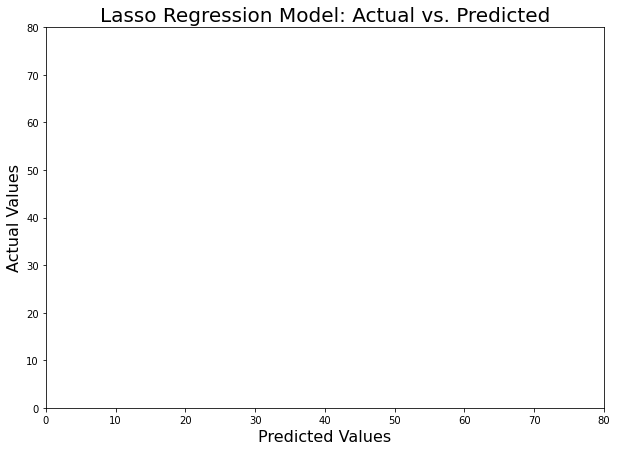

In [34]:
lm_las_predict = lm_las.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_las_predict, y_test)

z = np.polyfit(lm_las_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_las_predict, p(lm_las_predict), "m-")

plt.xlim(0,80)
plt.ylim(0,80)

plt.title('Lasso Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

Text(0, 0.5, 'Actual Values')

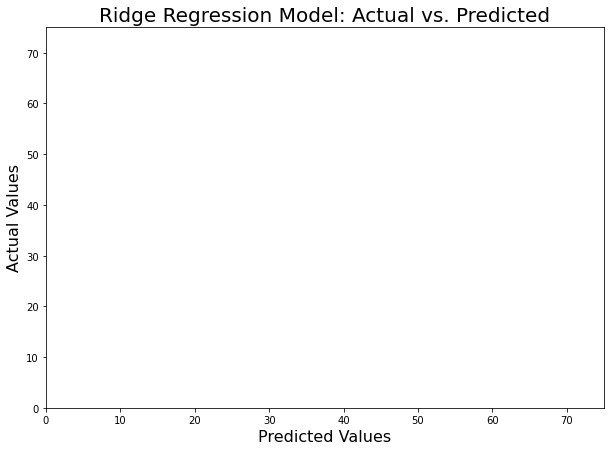

In [35]:
lm_reg_predict = lm_reg.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_reg_predict, y_test)

z = np.polyfit(lm_reg_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_reg_predict, p(lm_reg_predict), "m-")

plt.xlim(0,75)
plt.ylim(0,75)

plt.title('Ridge Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

Text(0, 0.5, 'Actual Values')

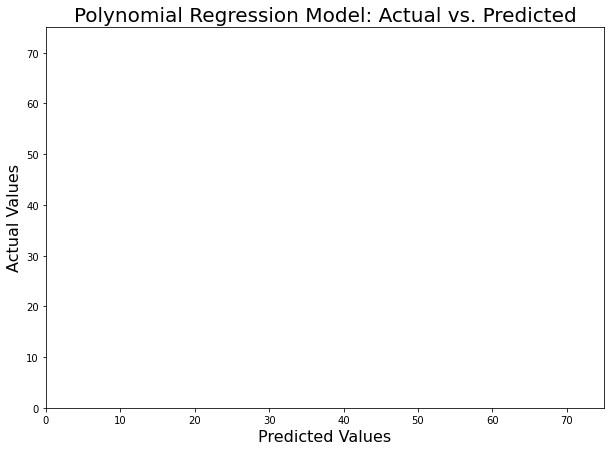

In [36]:
lm_poly_predict = lm_poly.predict(X_test)

plt.figure(figsize=(10,7))
plt.scatter(lm_poly_predict, y_test)

z = np.polyfit(lm_poly_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lm_poly_predict, p(lm_poly_predict), "m-")

plt.xlim(0,75)
plt.ylim(0,75)

plt.title('Polynomial Regression Model: Actual vs. Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16)

In [37]:
df_market_value_predicted = Football_df
df_market_value_predicted['Tested_Market_Value'] = pd.DataFrame(y_test)
df_market_value_predicted['Predicted_Market_Value'] = pd.DataFrame(lm_predict)

df_market_value_predicted = Football_df.dropna()

df_market_value_predicted

,age,games,goals,assists,hours_played,yellow_cards,red_cards,transfer_fee,market_value,club_market_value,player_position_0,player_position_Attack,player_position_Defender,player_position_Goalkeeper,player_position_Midfield,Tested_Market_Value,Predicted_Market_Value
0,25,27,25,16,40.450001,8,0,222000000,100000000,891180000,0.0,1.0,0.0,0.0,0.0,100000000.0,2.895191e+07
7,29,23,7,5,26.916700,9,0,66000000,50000000,671310000,0.0,1.0,0.0,0.0,0.0,50000000.0,5.953596e+06
13,24,1,0,0,1.500000,0,0,45000000,45000000,7810000,0.0,0.0,0.0,0.0,1.0,45000000.0,4.847222e+06
14,30,36,7,3,40.716702,3,0,38000000,45000000,56320000,0.0,0.0,0.0,0.0,1.0,45000000.0,3.161114e+06
28,25,38,9,5,52.383301,3,0,38000000,30000000,280170000,0.0,1.0,0.0,0.0,0.0,30000000.0,8.373183e+06
47,18,23,0,2,32.683300,6,0,18500000,25000000,17980000,0.0,0.0,1.0,0.0,0.0,25000000.0,9.205322e+06
53,31,37,1,1,47.466702,6,0,17000000,20000000,32560000,0.0,0.0,0.0,0.0,1.0,20000000.0,1.791340e+07
56,24,37,2,8,53.733299,7,0,22000000,20000000,493290000,0.0,0.0,1.0,0.0,0.0,20000000.0,1.362218e+07
61,28,29,7,6,32.483299,2,0,22500000,20000000,229680000,0.0,1.0,0.0,0.0,0.0,20000000.0,6.564428e+06
63,19,38,0,0,56.250000,2,0,8500000,18000000,83120000,0.0,0.0,0.0,1.0,0.0,18000000.0,1.388846e+07


In [38]:
df_market_value_predicted.iloc[:,-3:-1].mean()

player_position_Midfield           0.3
Tested_Market_Value         37300000.0
dtype: float64

In [39]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('market_value ~ transfer_fee', data=Football_df, 
return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           market_value   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     974.4
Date:                Sun, 14 Nov 2021   Prob (F-statistic):          8.80e-103
Time:                        18:09:47   Log-Likelihood:                -5987.5
No. Observations:                 349   AIC:                         1.198e+04
Df Residuals:                     347   BIC:                         1.199e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.059e+06   5.06e+05      4.066      0.000    1.06e+06    3.06e+06
transfer_fee     0.6142      0.020     31.216      0.000       0.575       0.653
==============================================================================
Omnibus:                       44.814   Durbin-Watson:                   1.186
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.933
Skew:                           0.248   Prob(JB):                     7.32e-61
Kurtosis:                       7.336   Cond. No.                     3.55e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

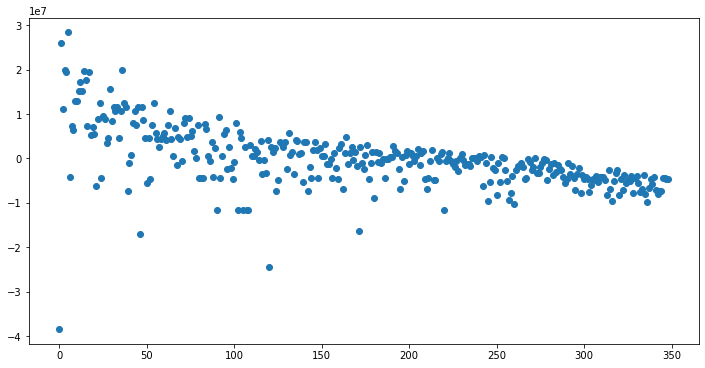

In [40]:
fit.resid.plot(style='o',figsize=(12,6))

# Define x and y

In [41]:
Football_df = Football_df.drop(['Tested_Market_Value','Predicted_Market_Value'], axis=1)

In [42]:
Football_df

,age,games,goals,assists,hours_played,yellow_cards,red_cards,transfer_fee,market_value,club_market_value,player_position_0,player_position_Attack,player_position_Defender,player_position_Goalkeeper,player_position_Midfield
0,25,27,25,16,40.450001,8,0,222000000,100000000,891180000,0.0,1.0,0.0,0.0,0.0
1,33,43,28,10,60.766701,4,1,117000000,100000000,816530000,0.0,1.0,0.0,0.0,0.0
2,25,42,21,15,49.883301,1,0,125000000,90000000,604800000,0.0,0.0,0.0,0.0,1.0
3,22,43,3,6,43.533298,5,0,70000000,65000000,671310000,0.0,0.0,0.0,0.0,1.0
4,25,51,0,0,76.500000,1,0,62500000,60000000,779850000,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,20,1,0,0,0.150000,0,0,10000000,800000,301820000,0.0,0.0,0.0,0.0,1.0
345,20,1,0,0,1.500000,0,0,5000000,800000,373820000,0.0,0.0,0.0,0.0,1.0
346,19,1,0,0,0.250000,0,0,5000000,800000,9050000,0.0,1.0,0.0,0.0,0.0
347,22,22,0,1,29.733299,3,0,5000000,600000,98420000,0.0,0.0,1.0,0.0,0.0


In [43]:
x=Football_df.drop(['market_value'],axis=1).values
y=Football_df['market_value'].values

In [44]:
print(x)

[[25. 27. 25. ...  0.  0.  0.]
 [33. 43. 28. ...  0.  0.  0.]
 [25. 42. 21. ...  0.  0.  1.]
 ...
 [19.  1.  0. ...  0.  0.  0.]
 [22. 22.  0. ...  1.  0.  0.]
 [22. 22.  0. ...  1.  0.  0.]]


In [45]:
print(y)

[100000000 100000000  90000000  65000000  60000000  55000000  50000000
  50000000  50000000  50000000  50000000  45000000  45000000  45000000
  45000000  45000000  40000000  40000000  40000000  35000000  35000000
  32000000  30000000  30000000  30000000  30000000  30000000  30000000
  30000000  30000000  28000000  25000000  25000000  25000000  25000000
  25000000  25000000  25000000  25000000  25000000  25000000  25000000
  25000000  25000000  25000000  25000000  25000000  25000000  23000000
  22000000  22000000  22000000  22000000  20000000  20000000  20000000
  20000000  20000000  20000000  20000000  20000000  20000000  20000000
  18000000  18000000  18000000  18000000  18000000  18000000  18000000
  18000000  18000000  18000000  18000000  18000000  18000000  18000000
  17000000  17000000  17000000  16000000  16000000  16000000  16000000
  16000000  15000000  15000000  15000000  15000000  15000000  15000000
  15000000  15000000  15000000  15000000  15000000  15000000  15000000
  1500

# Split the dataset in training set and test set

In [46]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

# Train the model on the training set

In [47]:
from sklearn.linear_model import LinearRegression
ml=LinearRegression()
ml.fit(x_train,y_train)

LinearRegression()

# Predict the test set results

In [48]:
y_pred=ml.predict(x_test)
print(y_pred)

[54362454.01288558 28603485.56462155 10598205.81262643  6357609.47062232
 11146321.03647992  7547912.28200095  8457347.39527939 16263380.23843439
 33454933.06908719  7564946.86983332  1493775.39606993 11611190.44736444
  6684516.00335122 12510619.00449293 16569941.44038645  8944467.99023493
 12176540.70087952  5339662.23958426  6686296.13208363 11127425.38546711
  5758957.5008559   9349895.1765456  13859808.77306451 10183434.72058195
 10895768.90157833 24050174.41532527 24429347.82266801 10361538.86401474
 13229477.2058765   9860243.58316397 15220682.41924483 17081067.79654323
  7803591.14981844 10581794.92350613 17010032.99956462 18435956.1515566
  7227521.8576295   6733647.7743753  16364685.64437085 35214095.23061368
  5503337.45268471  4248851.10532155  4449906.19161119  5373115.88523019
  4608510.13056363 24799039.79536248  7257230.81277217 10205536.94904163
  6585541.54650473  9299575.18911226 16311388.59828282  1742280.62689228
  2188044.27358252 43508901.03808942 17504155.101817

# Evaluate the model

In [49]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.5762814802206617

# Plot the results

Text(0.5, 1.0, 'Actual vs. Predicted')

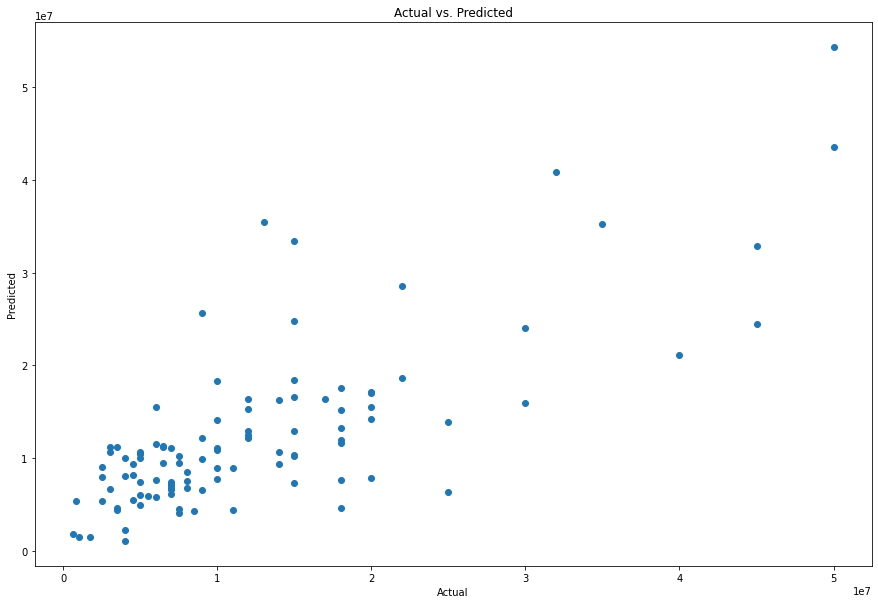

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

# Predicted Values

In [51]:
pred_y_df=pd.DataFrame({'Actual Value':y_test,'Predicted value':y_pred, 'Difference':y_test-y_pred})
pred_y_df[0:20]

,Actual Value,Predicted value,Difference
0,50000000,5.436245e+07,-4.362454e+06
1,22000000,2.860349e+07,-6.603486e+06
2,5000000,1.059821e+07,-5.598206e+06
3,25000000,6.357609e+06,1.864239e+07
4,3500000,1.114632e+07,-7.646321e+06
5,8000000,7.547912e+06,4.520877e+05
6,8000000,8.457347e+06,-4.573474e+05
7,14000000,1.626338e+07,-2.263380e+06
8,15000000,3.345493e+07,-1.845493e+07
9,6000000,7.564947e+06,-1.564947e+06
